In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# **Cards Image Classification**
In this In this exercise, I wanted to investigate whether training model from scratch or loading some pretrained model then do transfer learning works better for a image classification task. And in specific, I trained two models from scratch: the VGG-16 and resnet-34. So we could see whether the idea of training residuals actually outperforms regular CNNs.

The data set that we are using is the cards image dataset on kaggle. The task is to determine the rank and suit of the card. For more information, visit https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

In [3]:
import glob 
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np
import pandas as pd 

In [4]:
train_data_dir ='/kaggle/input/cards-image-datasetclassification/train' 
val_data_dir = '/kaggle/input/cards-image-datasetclassification/valid'


Perform data augmentation using ImageDataGenerator. Notice that I did not set horizontal_flip to be True. This is because most cards have their mark on the top left corner, so if I perform data augmentation by flipping randomly, the mark (which is probably the most obvious indicator of card types) becomes more difficult for the model to learn.

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.15,
    brightness_range = (0.3,0.8),
    shear_range = 0.2
    )
val_datagen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = train_datagen.flow_from_directory(
    directory = train_data_dir,
    target_size = (224,224),
    batch_size=32,
    # class_mode default value is clasification
)
val_generator = train_datagen.flow_from_directory(
    directory = val_data_dir,
    target_size = (224,224),
    batch_size=32,
)

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.


# **Building VGG-16 model**

In [6]:
def vgg_block(filters, x, repeats = 2):
    for i in range(repeats):
        x = Conv2D(filters = filters, kernel_size = 3, padding = 'same', activation = 'relu')(x)
        x = BatchNormalization()(x)
    x = MaxPool2D(strides = 2, padding = 'same')(x)
    return x

inputs = keras.Input(shape = (224, 224, 3))
x = vgg_block(64, inputs, 2)
x = vgg_block(128, x, 2)
x = vgg_block(256, x, 3)
x = vgg_block(512, x, 3)
x = vgg_block(512, x, 3)
x = Flatten()(x)
x = Dense(4096, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(53, activation = 'softmax')(x)
vgg = keras.Model(inputs, x)
vgg.summary()

2022-12-14 11:05:21.832623: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 11:05:21.929517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 11:05:21.930399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 11:05:21.932178: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856 

In [18]:
import tensorflow as tf
vgg.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])
with tf.device("/device:GPU:0"):
    
    history = vgg.fit_generator(
        train_generator,
        epochs=80,
        shuffle=True,
        verbose=1,
        validation_data=val_generator)

Epoch 1/50
239/239 [==============================] - 123s 508ms/step - loss: 12.6817 - accuracy: 0.0449 - val_loss: 5.0318 - val_accuracy: 0.0189
Epoch 2/50
239/239 [==============================] - 122s 509ms/step - loss: 3.8564 - accuracy: 0.0808 - val_loss: 3.6403 - val_accuracy: 0.1019
Epoch 3/50
239/239 [==============================] - 122s 508ms/step - loss: 3.5210 - accuracy: 0.1186 - val_loss: 3.2163 - val_accuracy: 0.1585
Epoch 4/50
239/239 [==============================] - 122s 512ms/step - loss: 3.3736 - accuracy: 0.1343 - val_loss: 2.9900 - val_accuracy: 0.1849
Epoch 5/50
239/239 [==============================] - 123s 515ms/step - loss: 3.2611 - accuracy: 0.1545 - val_loss: 2.7742 - val_accuracy: 0.2038
Epoch 6/50
239/239 [==============================] - 121s 507ms/step - loss: 3.1444 - accuracy: 0.1663 - val_loss: 2.7644 - val_accuracy: 0.2189
Epoch 7/50
239/239 [==============================] - 123s 514ms/step - loss: 3.0754 - accuracy: 0.1831 - val_loss: 2.7367 

I have to say the plots look extremely volatile to me. The actual fluctuations are so big that I had to use Numpy clip function for plotting. Apart from that, we can notice that the training loss is mostly less than the validation loss, which is probably due to two reasons:
1. the training loss is calculated during an epoch, while the validation loss is calculated after an epoch, at which stage the model is better at classifying cards
2. we have used dropout layer to prevent overfitting. This means that lots of neurons will be disabled during training, but not validation.



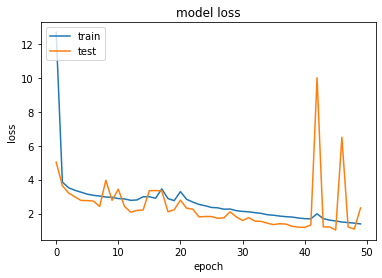

In [22]:
plt.plot(history.history['loss'])
plt.plot(np.clip(history.history['val_loss'], 0, 10))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

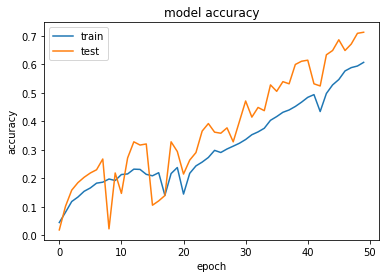

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# **Building resnet-34 model**
We can see from the model summary that even though resnet-34 is twice the depth of VGG-16, in terms of the number of parameters, it is much simpler than the VGG-16 model. 

In [13]:
from keras.layers import Add, AveragePooling2D
def conv_block(filters, x):
    x_shortcut = x
    
    
    x = Conv2D(filters = filters, kernel_size = 3,
               strides = 2, padding = 'same',
               activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters = filters, kernel_size = 3,
               padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    
    x_shortcut = Conv2D(filters = filters, kernel_size = 3,
                        strides = 2, padding = 'same',
                        activation = 'relu')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    x_shortcut = Conv2D(filters = filters, kernel_size = 3,
                        padding = 'same', activation = 'relu')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    
    x = Add()([x, x_shortcut])
    return x

def id_block(filters, x):
    x_shortcut = x
    
    x = Conv2D(filters = filters, kernel_size = 3,
               padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters = filters, kernel_size = 3,
               padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    
    x_shortcut = Conv2D(filters = filters, kernel_size = 3,
                        padding = 'same', activation = 'relu')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    x_shortcut = Conv2D(filters = filters, kernel_size = 3,
                        padding = 'same', activation = 'relu')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    
    x = Add()([x, x_shortcut])
    return x

def resnet_block(filters, x, repeats = 3):
    for i in range(repeats):
        x = id_block(filters, x)
    x = conv_block(filters*2, x)
    return x

inputs = keras.Input(shape = (224,224,3))
x = Conv2D(filters = 64, kernel_size = 7, strides = 2,
           padding = 'same', activation = 'relu')(inputs)
x = MaxPool2D(strides = 2, padding = 'same')(x)
x = resnet_block(64,x)
x = resnet_block(128,x)
x = resnet_block(256,x)
x = id_block(512,x)
x = id_block(512,x)
x = AveragePooling2D(strides = 2)(x)
x = Flatten()(x)
x = Dense(53, activation = 'softmax')(x)
resnet = keras.Model(inputs, x)
resnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_83[0][0]                  
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 56, 56, 64)   36928       max_pooling2d_11[0][0]           
____________________________________________________________________________________________

In [14]:
import tensorflow as tf
resnet.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])
with tf.device("/device:GPU:0"):
    
    history = resnet.fit_generator(
        train_generator,
        epochs=80,
        shuffle=True,
        verbose=1,
        validation_data=val_generator)

Epoch 1/50
239/239 [==============================] - 144s 482ms/step - loss: 5.2770 - accuracy: 0.0316 - val_loss: 17.2189 - val_accuracy: 0.0264
Epoch 2/50
239/239 [==============================] - 116s 486ms/step - loss: 3.8882 - accuracy: 0.0531 - val_loss: 4.0633 - val_accuracy: 0.0566
Epoch 3/50
239/239 [==============================] - 114s 477ms/step - loss: 3.3467 - accuracy: 0.1136 - val_loss: 3.2537 - val_accuracy: 0.1358
Epoch 4/50
239/239 [==============================] - 114s 477ms/step - loss: 3.0100 - accuracy: 0.1696 - val_loss: 2.8624 - val_accuracy: 0.2415
Epoch 5/50
239/239 [==============================] - 115s 481ms/step - loss: 2.6381 - accuracy: 0.2555 - val_loss: 2.3054 - val_accuracy: 0.2981
Epoch 6/50
239/239 [==============================] - 113s 472ms/step - loss: 2.4297 - accuracy: 0.2951 - val_loss: 2.9401 - val_accuracy: 0.3245
Epoch 7/50
239/239 [==============================] - 116s 484ms/step - loss: 2.2841 - accuracy: 0.3265 - val_loss: 2.1229 

OK this loss curve looks far more stable and reliable. We can see that resnet-34 converges faster than VGG-16 even with smaller number of parameters, which suggests that the residual idea is really useful. 

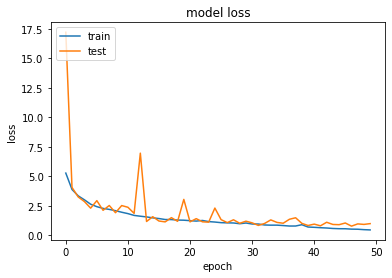

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

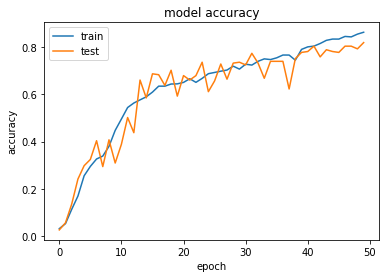

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# **Transfer Learning**
In practice, it is often a better idea to perform transfer learning than training models from scratch. This is because pretrained models already capture a lot of the basic features that are useful in many other classification tasks. Here we are going to load the pretrained mobilenet-v2 on imagenet dataset, freeze every layer except the output layer, and train it on our dataset again.

In [43]:
import tensorflow_hub as hub
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
inputs = keras.Input(shape = (224, 224, 3))
x = base_model(inputs, training = False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(53, activation = 'softmax')(x)
model = keras.Model(inputs, x)
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 53)                67893     
Total params: 2,325,877
Trainable params: 67,893
Non-trainable params: 2,257,984
_________________________________________________________________


In [44]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])
with tf.device("/device:GPU:0"):
    
    history = model.fit_generator(
        train_generator,
        epochs=50,
        shuffle=True,
        verbose=1,
        validation_data=val_generator)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
239/239 [==============================] - 106s 436ms/step - loss: 2.9664 - accuracy: 0.2131 - val_loss: 2.1254 - val_accuracy: 0.3472
Epoch 2/50
239/239 [==============================] - 105s 438ms/step - loss: 2.1896 - accuracy: 0.3707 - val_loss: 1.8551 - val_accuracy: 0.4189
Epoch 3/50
239/239 [==============================] - 103s 430ms/step - loss: 1.9562 - accuracy: 0.4390 - val_loss: 1.7294 - val_accuracy: 0.4906
Epoch 4/50
239/239 [==============================] - 102s 428ms/step - loss: 1.7880 - accuracy: 0.4805 - val_loss: 1.6704 - val_accuracy: 0.4906
Epoch 5/50
239/239 [==============================] - 102s 429ms/step - loss: 1.6852 - accuracy: 0.5067 - val_loss: 1.6937 - val_accuracy: 0.5170
Epoch 6/50
239/239 [==============================] - 103s 430ms/step - loss: 1.5900 - accuracy: 0.5324 - val_loss: 1.6570 - val_accuracy: 0.4906
Epoch 7/50
239/239 [==============================] - 102s 428ms/step - loss: 1.5026 - accuracy: 0.5497 - val_loss: 1.6269 -

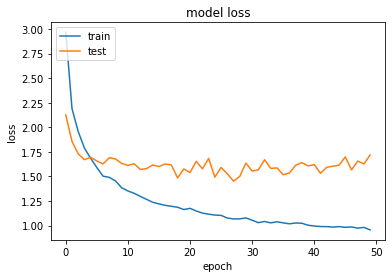

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

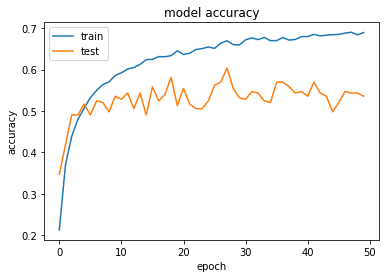

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

OK it looks like the model is not doing really well... This is probably because we have frozen too many layers. Only the features that are in the very end of the neural networks can be used for our prediction, but those features are usually tailored for one specific task. So another common practice is to fine-tune the model by defreezing some of the layers that are in the end and train it on our dataset again. Let's see how it looks.

In [47]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate = 0.0003),
    metrics=['accuracy'])
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_8 ( (None, 1280)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 53)                67893     
Total params: 2,325,877
Trainable params: 1,929,333
Non-trainable params: 396,544
_________________________________________________________________


In [49]:
with tf.device("/device:GPU:0"):
    
    history_fine_tuned = model.fit_generator(
        train_generator,
        epochs=80,
        initial_epoch = history.epoch[-1],
        shuffle=True,
        verbose=1,
        validation_data=val_generator)

Epoch 50/80
239/239 [==============================] - 108s 437ms/step - loss: 3.3283 - accuracy: 0.1107 - val_loss: 2.0881 - val_accuracy: 0.2906
Epoch 51/80
239/239 [==============================] - 103s 430ms/step - loss: 2.2347 - accuracy: 0.3012 - val_loss: 1.4654 - val_accuracy: 0.4830
Epoch 52/80
239/239 [==============================] - 103s 430ms/step - loss: 1.8151 - accuracy: 0.4397 - val_loss: 1.2649 - val_accuracy: 0.6113
Epoch 53/80
239/239 [==============================] - 104s 435ms/step - loss: 1.4569 - accuracy: 0.5603 - val_loss: 0.9443 - val_accuracy: 0.7208
Epoch 54/80
239/239 [==============================] - 103s 430ms/step - loss: 1.2404 - accuracy: 0.6254 - val_loss: 0.9662 - val_accuracy: 0.6906
Epoch 55/80
239/239 [==============================] - 103s 433ms/step - loss: 1.1076 - accuracy: 0.6725 - val_loss: 0.6766 - val_accuracy: 0.7811
Epoch 56/80
239/239 [==============================] - 106s 443ms/step - loss: 0.9839 - accuracy: 0.7105 - val_loss: 0

Great! It looks like fine-tuning really worked! Too bad I ran out of quota of the machine before plotting them.
In conclusion, I'll list the validation accuracy for each model below:
1. VGG-16: 71.32%. 
2. resnet-34: 81.89%.
3. Transfered mobilenet-v2: 90.94%